In [0]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd import Variable

In [0]:
# Image preprocessing
# transform = transforms.Compose([transforms.Resize(128),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(mean=(0.5, 0.5, 0.5),
#                                                      std=(0.5, 0.5, 0.5))])

# Image preprocessing
transform3 = transforms.Compose([transforms.Resize(128),
                                transforms.ToTensor()])

transform1 = transforms.Compose([transforms.Resize(128),
                                 transforms.Grayscale(),
                                transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(),
#                                 transforms.Normalize(mean=(0.5, 0.5, 0.5),
#                                                      std=(0.5, 0.5, 0.5))])

In [16]:
from torchvision.datasets import STL10
from skimage import io, color
from PIL import Image

class STL10GrayColor(STL10):
    
    def __getitem__(self, index):
        """
        Overwrite the original method to return a grayscaled image and
        the same image with the colors.
        
        Input:
            index(int): index of the desired image
            
        Return:
            tensor_gray_img(torch.Tensor): image in black and white
            tensor_img(torch.Tensor): image in RGB
        """
        img = self.data[index]

        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)
            
            # Convert img RGB -> Lab
            lab_img = color.rgb2lab(img)
            
            # Transpose the lab img: dim 128x128x3 -> 3x128x128
            L, a, b = np.transpose(lab_img, (2, 0, 1))
            
            # Normalize
            gray_img = (L + 128) / 255
            color_img = np.asarray(img, dtype=np.float32) / 255
            
            # Transform numpy array to torch tensor
            tensor_gray_img = torch.tensor(gray_img.astype(np.float32))
            tensor_img = torch.tensor(np.transpose(color_img, (2, 0, 1)))
            

        return (tensor_gray_img, tensor_img)
    
# Image preprocessing
transform = transforms.Compose([transforms.Resize(128)])

# Load STL10 dataset
stl10_trainset = STL10GrayColor(root="./data",
                                split='train',
                                download=True,
                                transform=transform)

# Parameters
params_loader = {'batch_size': 32,
                 'shuffle': False}

train_loader = DataLoader(stl10_trainset, **params_loader)

Files already downloaded and verified


In [0]:
stl10 = dsets.STL10(root="./data",
                   download=True,
                    split='train+unlabeled',
                  transform=transform3)


# Load CIFAR 10 dataset
# cifar_trainset = dsets.CIFAR10(root="./data",
#                                train=True,
#                                download=True,
#                                transform=transform)
# 


Files already downloaded and verified


In [0]:
batch_size = 128
# Parameters loader
# cifar_loader = DataLoader(cifar_trainset,
#                           batch_size=batch_size,
#                           shuffle=True)
# 
shuffle = False
stl10_loader = DataLoader(stl10,
                         batch_size=batch_size,
                         shuffle=shuffle)



(128, 128, 3)


NameError: ignored

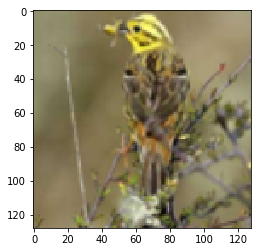

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color

def plot_img(images):
    f, a = plt.subplots(1, len(images), figsize=(14, 6))
    
    for i, image in enumerate(images):
        # img = image.permute(1, 2, 0).numpy()
        print(image.shape)
        a[i].imshow(image, cmap=plt.cm.gray)
        
        a[i].set_xticks(())
        a[i].set_yticks(())
    

    plt.show()
    

for image, _ in stl10_loader:
    img = image[0].permute(1, 2, 0).numpy()
    # plot_img(image[:5])
    # print(img.shape)
    # print(img)
    plt.imshow(img)
    
    lab_img = color.rgb2lab(img)
    print(lab_img.shape)
    new_img = np.transpose(lab_img, (2, 0, 1))
    
    L, a, b = new_img
    
    other_gray = color.rgb2grey(img)
    
    img_final = stl10_loader2.dataset[0][0].permute(1, 2, 0).numpy()
    
    print(img_final.shape)
    img_final = img_final[:, :, 0]
    print("<<<<", img_final.shape)
    gray = (L+128)/255
    
    print("---", gray.shape)
    
    tmp = sum([val1 == val2 for val1, val2 in zip(gray, img_final)])
    
    print(tmp)

    
    plot_img([gray, other_gray, img_final])
    
    
    reconstructed = np.array([gray*255-127, a, b])
    trans_rec = np.transpose(reconstructed, (1, 2, 0))
    print(trans_rec.shape)
    
    plt.imshow(color.lab2rgb(trans_rec))
    # print(image.shape)
    # vutils.save_image(image, 
    #                   './real_samples.png',
    #                   normalize=True)
    break

In [0]:
# Generator model

class Generator(nn.Module):
    def __init__(self, Z_dim, ngf, ncc):
        super(Generator, self).__init__()
        
        self.layers = nn.Sequential(
            # input is Z, going into a convolution
            # in_channels, out_channels, kernel_size, stride=1, padding=0
            # formula: (in-1)* stride - 2*padding + kernel_size
            # 128 -> 
            
            # 1 -> (1-1)*1 - 2*0 + 4 = 4
            # in: (100 x 4 x 4)
            nn.ConvTranspose2d(Z_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (ncc) x 64 x 64
            nn.ConvTranspose2d(ngf, ncc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (ncc) x 128 x 128
        )
        
    def forward(self, input_):
        output = self.layers(input_)
        # print(output.shape)
        return output

In [0]:
# Discriminator model

class Discriminator(nn.Module):
    def __init__(self, ndf, ncc):
        super(Discriminator, self).__init__()
        
        self.layers = nn.Sequential(
            # in_channels, out_channels, kernel_size, stride=1, padding=0, 
            # Formula: (H + 2*padding -kernel_size)/stride + 1
            # (128 + 2*2 - 4)/2+1
            # in: 3 x 128 x 128
            # out: 128 x 65 x 65 (64 x 33 x 33)
            nn.Conv2d(ncc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            
            #out: 256 x 33 x 33 (128 x 17 x 17)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2),
            
            # out 512 x 17 x 17 (256 x 9 x 9)
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2),
            
            # out 1024 x 9 x 9 (512 x 5 x 5)
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2),
            
            # # out: 1024 x 5 x 5 
            nn.Conv2d(ndf*8, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2),
            
            # out (1 x 1 x 1)
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
            
        )
    
    def forward(self, input_):
        # print("before")
        output = self.layers(input_)
        # print(output.shape)
        # print("after")
        return output.view(-1, 1).squeeze(1)

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
# Dimension of the latent space
Z_dim = 100

# Number of color channel in the final image
ncc = 2

# Number of ?
ngf, ndf = 128, 128
# ngf, ndf = 64, 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [8]:
netG = Generator(Z_dim, ngf, ncc).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(ndf, 3).to(device)
netD.apply(weights_init)
print(netD)

Generator(
  (layers): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
    (14): ConvTranspose2d(128, 2, kernel_siz

In [0]:
# Setup loss function
criterion = nn.BCELoss()
criterion = nn.MSELoss()
batch_size = params_loader['batch_size']

learning_rate = 0.0002
nb_epochs = 30

# Setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(0.5, 0.999))


fixed_noise = torch.randn(batch_size, Z_dim, 1, 1, device=device)

real_label = 1
fake_label = 0



real_labels = torch.full((batch_size,), real_label, device=device)
fake_labels = torch.full((batch_size,), fake_label, device=device)

In [51]:
import numpy as np
import warnings

def convert_lab2rgb(L, ab):
    ab = ab*100
    # Normalize grayscale to rgb
    L = L*255-128
    
    # Add missing dim:
    # batch_size x img_size x img_size -> batch_size x 1 x img_size x img_size
    L.unsqueeze_(1)
    
    # Concatanet gray tensor with ab tensor
    colorized_img = torch.cat((L, ab), 1)
    
    # Convert the color space: lab -> rgb
    reversed_img = colorized_img.cpu().double().detach().permute(0, 2, 3, 1).numpy()

    for i in range(reversed_img.shape[0]):
        # Remove warning of bad color range.
        warnings.simplefilter("ignore")
        reversed_img[i,:,:,:] = color.lab2rgb(reversed_img[i,:,:,:])
        
    output = torch.from_numpy(reversed_img).float().permute(0, 3, 1, 2)
    
    return output.to(device)
    

for epoch in range(nb_epochs):
    for i, (gray_img, color_img) in enumerate(train_loader, 0):
        # Load data on GPU
        gray_img = gray_img.to(device)
        color_img = color_img.to(device)
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        
        # Feed the discriminator with real image
        output = netD(color_img)

        errD_real = criterion(output, real_labels) # 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_real.backward()
        
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, Z_dim, 1, 1, device=device)
        # noise will be replace.
        
        fake_colors = netG(noise)
        
        print(fake_colors.shape)
        
        colorized_img = convert_lab2rgb(gray_img, fake_colors)
        
        break

        output = netD(fake.detach())
        
        errD_fake = criterion(output, fake_labels) # 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()

        output = netD(fake)
        errG = criterion(output, real_labels) # 0.5 * torch.mean((output-label)**2) # criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        print(f'[{epoch}/{nb_epochs}][{i}/{len(stl10_loader)}]\
              Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}\
              D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                              './real_samples.png',
                              normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                              f'./fake_samples_epoch_{epoch}.png',
                              normalize=True)
        
        break
    break

    # do checkpointing
    torch.save(netG.state_dict(), f'./netG_epoch_{epoch}.pth')
    torch.save(netD.state_dict(), f'./netD_epoch_{epoch}.pth')
        

torch.Size([32, 2, 128, 128])
